In [1]:
# University of Toronto
# Faculty of Information
# INF2178 
# Chi-shiun Yang 
# 1009916897 
# Mar 31, 2024 
# Assignment 4

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import numpy as np
from IPython.display import Markdown, display

# load data
df = pd.read_csv('INF2178_A4_data.csv')
print(len(df))
df.head()

294


,Unnamed: 0,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444


In [2]:
# drop columns with only one visit
# get all ids
ids = df['Subject ID'].unique()
# for each id
for id in ids:
    # if it appears only once
    if len(df[df['Subject ID'] == id]) == 1:
        # updata the df to the one without it
        df = df[df['Subject ID'] != id]

# separate df to 1st and 2nd visit
df_1 = df[df["Visit"] == 1].set_index('Subject ID')
df_2 = df[df["Visit"] == 2].set_index('Subject ID')

# get the corresponding column
data = {'ID': df_1.index, 'Group': df_1["Group"], "M/F": df_1["M/F"], 
        'eTIV_1': df_1["eTIV"], 'eTIV_2': df_2["eTIV"], 'nWBV_1': df_1["nWBV"], 'nWBV_2': df_2["nWBV"]}
df_new = pd.DataFrame(data)
df_new

,ID,Group,M/F,eTIV_1,eTIV_2,nWBV_1,nWBV_2
Subject ID,,,,,,,
OAS2_0001,OAS2_0001,Nondemented,M,1987,2004,0.696,0.681
OAS2_0002,OAS2_0002,Demented,M,1678,1738,0.736,0.713
OAS2_0004,OAS2_0004,Nondemented,F,1215,1200,0.710,0.718
OAS2_0005,OAS2_0005,Nondemented,M,1689,1701,0.712,0.711
OAS2_0008,OAS2_0008,Nondemented,F,1272,1257,0.698,0.703
...,...,...,...,...,...,...,...
OAS2_0182,OAS2_0182,Demented,M,1661,1654,0.698,0.696
OAS2_0183,OAS2_0183,Nondemented,F,1495,1506,0.746,0.740
OAS2_0184,OAS2_0184,Demented,F,1354,1351,0.733,0.708


In [3]:
# the function to run repeated measures anova
def repeated_measures(df, df_new, factor_col, variable_col):
    # boxplot to see the data distribution by different visit
    ax = sns.boxplot(x=factor_col, y=variable_col, data=df, color='#99c2a2')
    ax = sns.swarmplot(x=factor_col, y=variable_col, data=df, color='#7d0013', size=4)
    plt.show()

    # distribution plots
    ax1 = sns.distplot(df_new[variable_col + "_1"], label = '1st visit')
    ax2 = sns.distplot(df_new[variable_col + "_2"], label = '2nd visit')
    plt.xlabel(variable_col)
    plt.ylabel('Distribution of ' + variable_col)
    plt.legend()
    plt.show()

    # repeated measures one-way ANOVA - 1
    res = pg.rm_anova(dv=variable_col, within=factor_col, subject='Subject ID', data=df, detailed=True)
    display(res)

    # if there are more than two groups post hoc test can find where the difference is
    # but if there are only two groups, the result will be same as the anova test
    # post hoc tests: paired t-tests with FDR-BH corrections
    post_hocs = pg.pairwise_ttests(dv=variable_col, within=factor_col, subject='Subject ID', padjust='fdr_bh', data=df)
    display(post_hocs)

    # repeated measures one-way ANOVA details
    print("Calculation details")
    # Calculate means for each group
    mu1 = df_new[variable_col + "_1"].values.mean()
    mu2 = df_new[variable_col + "_2"].values.mean()
    #Grand mean
    mu = (mu1 + mu2) / 2
    display(Markdown('$\overline{{x}}_1 = {}$'.format(round(mu1,3))))
    display(Markdown('$\overline{{x}}_2 = {}$'.format(round(mu2,3))))
    display(Markdown('$\overline{{x}} = {}$'.format(round(mu,3))))

    # Number of samples for each group:
    n = len(df_new)
    # Here the number of samples is the same for all groups:
    n1 = n
    n2 = n

    # SS groups:
    SSgroups= n1*(mu1-mu)**2 + n2*(mu2-mu)**2
    display(Markdown("$SS_{{groups}} = {}$".format(round(SSgroups,3))))

    # Group 1 is a column of the dataset (1st visit):
    group1 = df_new[variable_col + "_1"].values
    # Now calculate sum (x - mu1)^2 for all x values in this group:
    ss_group1 = np.sum((group1-mu1)**2)
    display(Markdown('SS for group 1 ={}'.format(ss_group1)))

    # Group 2 is a column of the dataset (2nd visit):
    group2 = df_new[variable_col + "_2"].values
    # Now calculate sum (x - mu1)^2 for all x values in this group:
    ss_group2 = np.sum((group2-mu2)**2)
    display(Markdown('SS for group 2 ={}'.format(ss_group2)))

    # all group
    SSw = ss_group1 + ss_group2
    display(Markdown('$SS_w = {}$'.format(round(SSw,3))))

    # subjects
    k=2.0
    subject_means = (df_new[variable_col + "_1"] + df_new[variable_col + "_2"]) / 2
    SSsubjects = k * np.sum( (subject_means - mu)**2 )
    display(Markdown('$SS_{{subjects}} = {}$'.format(round(SSsubjects,3))))
    
    # error
    SSerror = SSw - SSsubjects
    display(Markdown('$SS_{{error}} = {}$'.format(round(SSerror,3))))

    # Degrees of freedom for groups:
    df1 = k-1
    # Degrees of freedom for error
    df2 = (n-1)*(k-1)
    MSgroups = SSgroups/df1
    MSerror = SSerror/df2
    Fstatistic = MSgroups/MSerror
    display(Markdown('$MS_{{groups}} = {}$'.format(round(MSgroups,3))))
    display(Markdown('$MS_{{error}} = {}$'.format(round(MSerror,3))))
    display(Markdown('$F$-statistic $= {}$'.format(round(Fstatistic,3))))
    display(Markdown('DF1 = {}, DF2 = {}'.format(int(df1),int(df2))))
    

    # check assumptions
    # mauchly's test of sphericity
    print("Sphericity: ", pg.sphericity(data=df, dv=variable_col, within=factor_col, subject='Subject ID')[-1])
    # test of normality
    display(pg.normality(data=df, dv=variable_col, group=factor_col))
    # test of homoscedasticity (equality of variance)
    display(pg.homoscedasticity(data=df, dv=variable_col, group=factor_col, method='levene'))




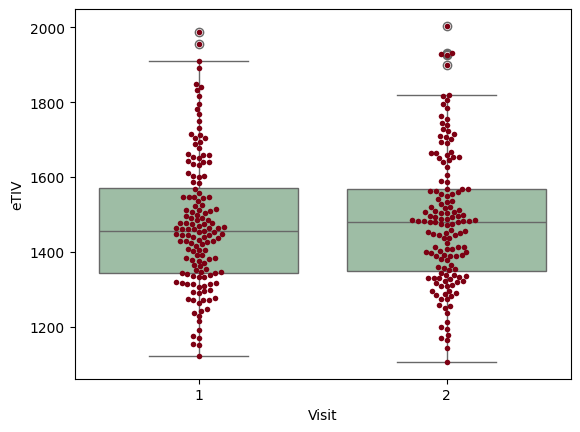

/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3237246204.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(df_new[variable_col + "_1"], label = '1st visit')
/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3237246204.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



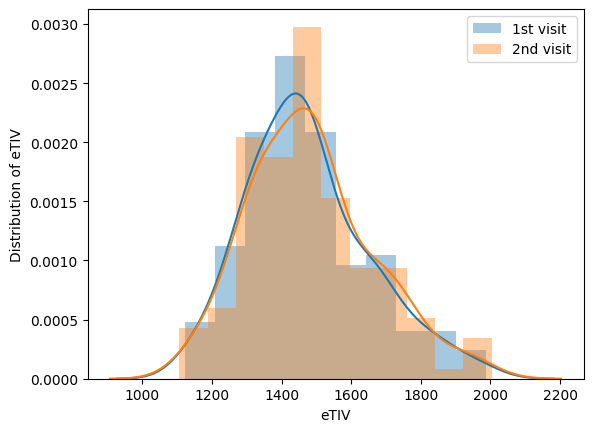

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Visit,5573.920139,1,5573.920139,9.246696,0.002807,0.000619,1.0
1,Error,86200.579861,143,602.801258,NaN,NaN,NaN,NaN


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are no

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Visit,1,2,True,True,-3.040838,143.0,two-sided,0.002807,7.532,-0.049472


Calculation details


$\overline{x}_1 = 1474.667$

$\overline{x}_2 = 1483.465$

$\overline{x} = 1479.066$

$SS_{groups} = 5573.92$

SS for group 1 =4417834.0

SS for group 2 =4581133.826388889

$SS_w = 8998967.826$

$SS_{subjects} = 8912767.247$

$SS_{error} = 86200.58$

$MS_{groups} = 5573.92$

$MS_{error} = 602.801$

$F$-statistic $= 9.247$

DF1 = 1, DF2 = 143

Sphericity:  1.0


,W,pval,normal
Visit,,,
1,0.971632,0.004366,False
2,0.977016,0.015925,False


,W,pval,equal_var
levene,0.088163,0.766742,True


In [4]:
# Research Question 1 - eTIV
repeated_measures(df, df_new, "Visit", "eTIV")

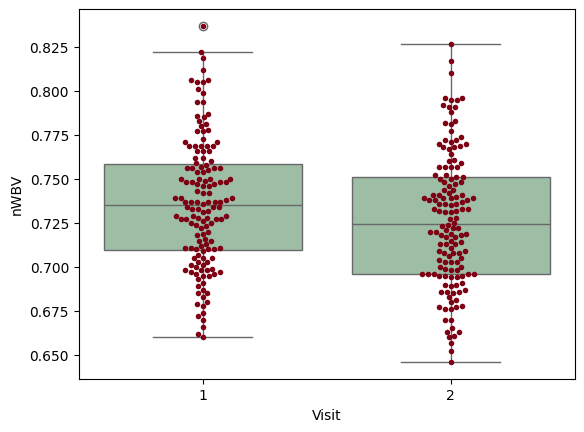

/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3237246204.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(df_new[variable_col + "_1"], label = '1st visit')
/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3237246204.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



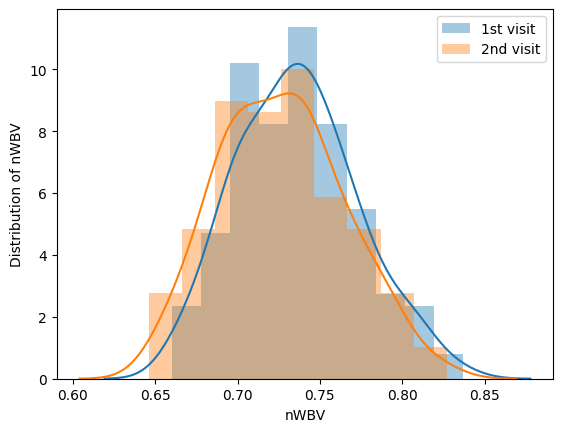

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,Visit,0.006508,1,0.006508,93.553164,2.460952e-17,0.016131,1.0
1,Error,0.009947,143,0.000070,NaN,NaN,NaN,NaN


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are no

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,Visit,1,2,True,True,9.672288,143.0,two-sided,2.460952e-17,2.258e+14,0.254531


Calculation details


$\overline{x}_1 = 0.736$

$\overline{x}_2 = 0.726$

$\overline{x} = 0.731$

$SS_{groups} = 0.007$

SS for group 1 =0.1924420000000001

SS for group 2 =0.2044599930555556

$SS_w = 0.397$

$SS_{subjects} = 0.387$

$SS_{error} = 0.01$

$MS_{groups} = 0.007$

$MS_{error} = 0.0$

$F$-statistic $= 93.553$

DF1 = 1, DF2 = 143

Sphericity:  1.0


,W,pval,normal
Visit,,,
1,0.989711,0.371438,True
2,0.989654,0.366718,True


,W,pval,equal_var
levene,0.404317,0.525377,True


In [5]:
# Research Question 1 - nWBV
repeated_measures(df, df_new, "Visit", "nWBV")

In [6]:
# function of mixed anova
def mixed_anova(df, df_1, df_2, group_col, factor_col, variable_col):
    # draw the point plot
    sns.pointplot(data=df, x=factor_col, y=variable_col, hue=group_col, dodge=True, palette='colorblind', markers = ['o', 's', 'v'], capsize=.1, errwidth=1)
    plt.show()
    # display the data summary
    display(df.groupby([factor_col, group_col])[variable_col].agg(['mean', 'std']).round(2))
    # Compute the two-way mixed-design ANOVA
    aov = pg.mixed_anova(dv=variable_col, within=factor_col, between=group_col, subject='Subject ID', data=df)
    # Pretty printing of ANOVA summary
    pg.print_table(aov)
    # post hoc tests
    # if there are more than two groups post hoc test can find where the difference is
    # but if there are only two groups, the result will be same as the anova test
    posthocs = pg.pairwise_ttests(dv=variable_col, within=factor_col, between=group_col,
                              subject='Subject ID', data=df)
    pg.print_table(posthocs)


    # check assumptions
    # mauchly's test of sphericity
    print("Sphericity: ", pg.sphericity(data=df, dv=variable_col, within=factor_col, subject='Subject ID')[-1])
    # test of normality
    df['group_factor']= df[group_col] + '-'+ df[factor_col].apply(str)
    display(pg.normality(data=df, dv=variable_col, group='group_factor'))
    df.drop(columns=['group_factor'])
    # test of homoscedasticity (equality of variance)
    # first visit
    display(pg.homoscedasticity(data=df_1, dv=variable_col, group=group_col, method='levene'))
    # second visit
    display(pg.homoscedasticity(data=df_2, dv=variable_col, group=group_col, method='levene'))

        

/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3069820166.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x=factor_col, y=variable_col, hue=group_col, dodge=True, palette='colorblind', markers = ['o', 's', 'v'], capsize=.1, errwidth=1)


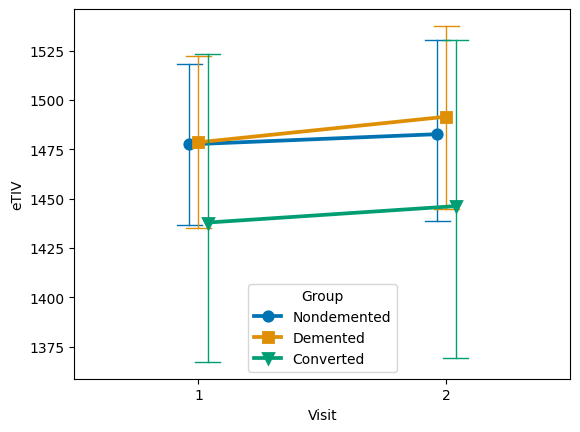

mean     std
Visit Group                       
1     Converted    1437.92  143.77
      Demented     1478.56  175.67
      Nondemented  1477.51  182.19
2     Converted    1446.25  150.29
      Demented     1491.55  177.26
      Nondemented  1482.69  186.32

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are no


ANOVA SUMMARY

Source              SS    DF1    DF2         MS      F    p-unc    np2      eps
-----------  ---------  -----  -----  ---------  -----  -------  -----  -------
Group        37424.708      2    141  18712.354  0.297    0.743  0.004  nan
Visit         5573.920      1    141   5573.920  9.225    0.003  0.061    1.000
Interaction   1004.783      2    141    502.392  0.831    0.438  0.012  nan


POST HOC TESTS

Contrast       Visit    A          B            Paired    Parametric         T      dof  alternative      p-unc    BF10    hedges
-------------  -------  ---------  -----------  --------  ------------  ------  -------  -------------  -------  ------  --------
Visit          -        1          2            True      True          -3.041  143.000  two-sided        0.003   7.532    -0.049
Group          -        Converted  Demented     False     True          -0.897   17.630  two-sided        0.382   0.423    -0.249
Group          -        Converted  Nondemented  False 

,W,pval,normal
group_factor,,,
Nondemented-1,0.970855,0.101884,True
Nondemented-2,0.975840,0.194094,True
Demented-1,0.965476,0.078360,True
Demented-2,0.971023,0.149658,True
Converted-2,0.915798,0.252988,True
Converted-1,0.921541,0.298938,True


,W,pval,equal_var
levene,0.437497,0.646524,True


,W,pval,equal_var
levene,0.405672,0.667304,True


In [7]:
# Research question 2 - eTIV
mixed_anova(df, df_1, df_2, "Group", "Visit", "eTIV")

/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3069820166.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x=factor_col, y=variable_col, hue=group_col, dodge=True, palette='colorblind', markers = ['o', 's', 'v'], capsize=.1, errwidth=1)


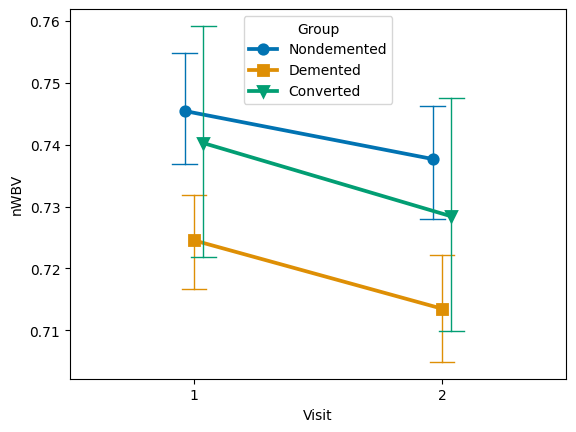

mean   std
Visit Group                  
1     Converted    0.74  0.04
      Demented     0.72  0.03
      Nondemented  0.75  0.04
2     Converted    0.73  0.04
      Demented     0.71  0.03
      Nondemented  0.74  0.04


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
Group        0.034      2    141  0.017   6.712    0.002  0.087  nan
Visit        0.007      1    141  0.007  94.251    0.000  0.401    1.000
Interaction  0.000      2    141  0.000   1.534    0.219  0.021  nan



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are no


POST HOC TESTS

Contrast       Visit    A          B            Paired    Parametric         T      dof  alternative      p-unc                 BF10    hedges
-------------  -------  ---------  -----------  --------  ------------  ------  -------  -------------  -------  -------------------  --------
Visit          -        1          2            True      True           9.672  143.000  two-sided        0.000  225800000000000.000     0.255
Group          -        Converted  Demented     False     True           1.401   14.676  two-sided        0.182                0.668     0.469
Group          -        Converted  Nondemented  False     True          -0.648   15.832  two-sided        0.527                0.361    -0.188
Group          -        Demented   Nondemented  False     True          -3.690  129.436  two-sided        0.000               75.094    -0.633
Visit * Group  1        Converted  Demented     False     True           1.444   14.626  two-sided        0.170              

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:585: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "Parametric"] = parametric


,W,pval,normal
group_factor,,,
Nondemented-1,0.987987,0.744254,True
Nondemented-2,0.983956,0.510870,True
Demented-1,0.991941,0.957787,True
Demented-2,0.979475,0.384696,True
Converted-2,0.940329,0.502351,True
Converted-1,0.941132,0.512879,True


,W,pval,equal_var
levene,1.093166,0.337977,True


,W,pval,equal_var
levene,0.298582,0.742338,True


In [8]:
# Research question 2 - nWBV
mixed_anova(df, df_1, df_2, "Group", "Visit", "nWBV")

/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3069820166.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x=factor_col, y=variable_col, hue=group_col, dodge=True, palette='colorblind', markers = ['o', 's', 'v'], capsize=.1, errwidth=1)


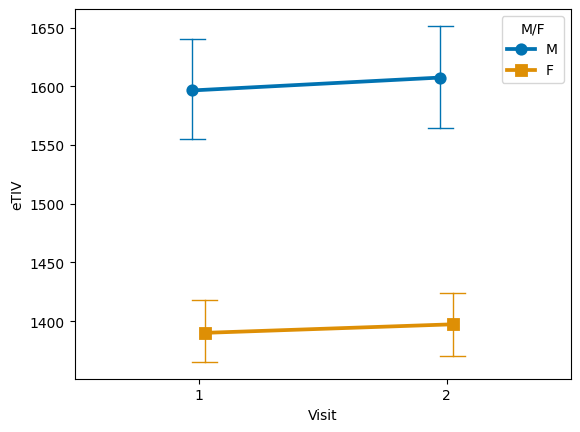

mean     std
Visit M/F                 
1     F    1390.06  123.52
      M    1596.56  168.73
2     F    1397.34  127.47
      M    1607.54  170.06


ANOVA SUMMARY

Source                SS    DF1    DF2           MS       F    p-unc    np2      eps
-----------  -----------  -----  -----  -----------  ------  -------  -----  -------
M/F          3023632.352      1    142  3023632.352  72.906    0.000  0.339  nan
Visit           5573.920      1    142     5573.920   9.208    0.003  0.061    1.000
Interaction      238.477      1    142      238.477   0.394    0.531  0.003  nan


POST HOC TESTS

Contrast     Visit    A    B    Paired    Parametric         T      dof  alternative      p-unc             BF10    hedges
-----------  -------  ---  ---  --------  ------------  ------  -------  -------------  -------  ---------------  --------
Visit        -        1    2    True      True          -3.041  143.000  two-sided        0.003            7.532    -0.049
M/F          -        F    M    False     True          -8.097  100.491  two-sided        0.000  25290000000.000    -1.439
Visit * M/F  1        F    M    False     True          -

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are no

,W,pval,normal
group_factor,,,
M-1,0.977129,0.330035,True
M-2,0.980269,0.451541,True
F-1,0.986181,0.502625,True
F-2,0.987335,0.578564,True


,W,pval,equal_var
levene,7.954123,0.005485,False


,W,pval,equal_var
levene,6.764949,0.010281,False


In [9]:
# Research question 3 - eTIV
mixed_anova(df, df_1, df_2, "M/F", "Visit", "eTIV")

/var/folders/l0/kcbhgwg14k10zsq_246jw9sw0000gn/T/ipykernel_8720/3069820166.py:4: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(data=df, x=factor_col, y=variable_col, hue=group_col, dodge=True, palette='colorblind', markers = ['o', 's', 'v'], capsize=.1, errwidth=1)


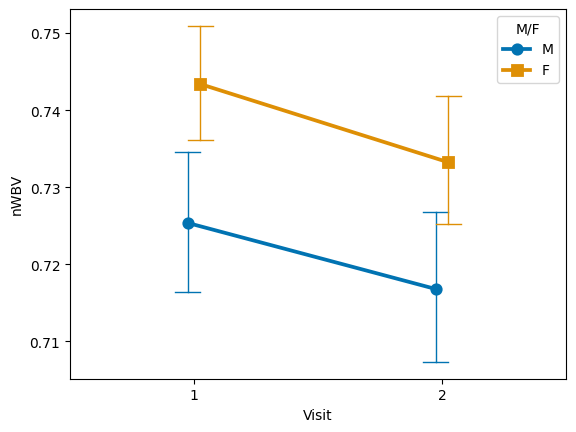

mean   std
Visit M/F            
1     F    0.74  0.04
      M    0.73  0.04
2     F    0.73  0.04
      M    0.72  0.04


ANOVA SUMMARY

Source          SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------  -----  -----  -----  -----  ------  -------  -----  -------
M/F          0.021      1    142  0.021   8.030    0.005  0.054  nan
Visit        0.007      1    142  0.007  93.305    0.000  0.397    1.000
Interaction  0.000      1    142  0.000   0.621    0.432  0.004  nan


POST HOC TESTS

Contrast     Visit    A    B    Paired    Parametric        T      dof  alternative      p-unc                 BF10    hedges
-----------  -------  ---  ---  --------  ------------  -----  -------  -------------  -------  -------------------  --------
Visit        -        1    2    True      True          9.672  143.000  two-sided        0.000  225800000000000.000     0.255
M/F          -        F    M    False     True          2.821  122.930  two-sided        0.006                6.506     0.478
Visit * M/F  1        F    M    False     True          2.974  124.056  two-sided        0.004           

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stats.loc[:, "A"] = A
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are no

,W,pval,normal
group_factor,,,
M-1,0.962159,0.063741,True
M-2,0.963148,0.071178,True
F-1,0.989621,0.737585,True
F-2,0.989690,0.742300,True


,W,pval,equal_var
levene,0.047932,0.827015,True


,W,pval,equal_var
levene,0.000124,0.991132,True


In [10]:
# Research question 3 - nWBV
mixed_anova(df, df_1, df_2, "M/F", "Visit", "nWBV")

Sample size needed in each group: 45.451


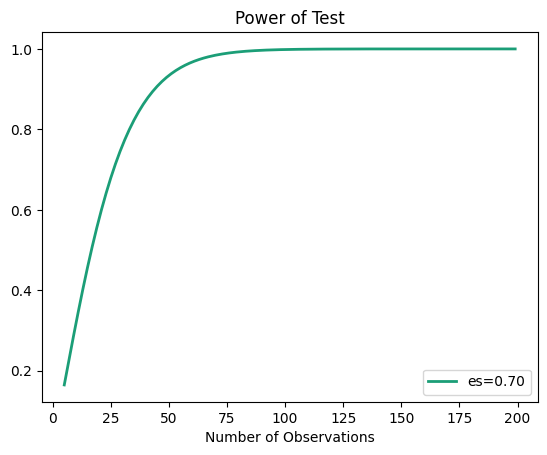

In [11]:
# statistical power for t-tests
# import required modules
from statsmodels.stats.power import TTestIndPower

# perform power analysis to find sample size for given effect
obj = TTestIndPower()

power = 0.91
effect_size = 0.7
alpha = 0.05
n = obj.solve_power(effect_size=effect_size, alpha=alpha, power=power,
					ratio=1, alternative='two-sided')

print('Sample size needed in each group: {:.3f}'.format(n))

# power curves
# power analysis varying parameters
sample_sizes = np.array(range(5, 200))

# plot power curve
obj = TTestIndPower()
obj.plot_power(dep_var='nobs', nobs=sample_sizes,
			effect_size=[effect_size])

plt.show()
